# PINN Burger's Ec.

This Notebook is the result of my first approach to the Physical-Informed Neural Network. With this notebook I seek to clarify and consolidate the information I have been able to find about this algorithm. For this I have based my work on:

Original Work: Maziar Raissi, Paris Perdikaris, and George Em Karniadakis

Github Repo : https://github.com/maziarraissi/PINNs

Link: https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI, title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations}, author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em}, journal={arXiv preprint arXiv:1711.10561}, year={2017} }

@article{raissi2017physicsII, title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations}, author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em}, journal={arXiv preprint arXiv:1711.10566}, year={2017} }

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io
import random

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.auto import tqdm
import torch.nn as nn

C:\Users\jandr\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jandr\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\jandr\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 1. Introduction
### 1.1 Burgers' Ecuation

Burgers' equation or Bateman–Burgers equation is a fundamental partial differential equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation was first introduced by Harry Bateman in 1915 and later studied by Johannes Martinus Burgers in 1948.

The one-dimensional Burger Eq. is: 

$ \frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} - \upsilon\frac{\partial^2 u}{\partial x^2} = 0 $

such that $ x $ belongs to $ [-1,1] $, t belongs to $ [0,1] $ and where $ t_d $ is the diffusion term. For this case we will take the define values such that:
* $ t_d = 0.01/pi $
* Initial condition: $ u(0,x) = sin(pi*x) $ 
* Contour line condition: $ u(t,-1) = u(t,1) = 0 $ 

## 2. Data
To train and test the PINN we need to have the solution of the Burgers equation for this boundary condition explained above, $ u(x,t) $. In the original working Repo we have access to the file *burgers_shock.mat*, this file contains the solution $ u(x,t) $ for this case. 


Lengitude x:  256
Lengitude t:  100
Number of points:  25600
image dimension:  (256, 100)


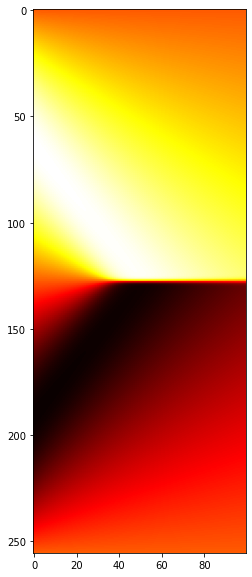

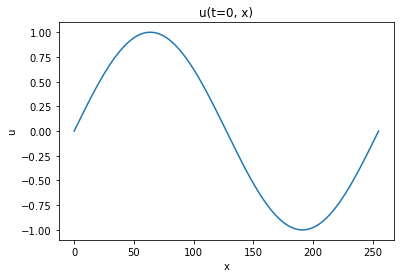

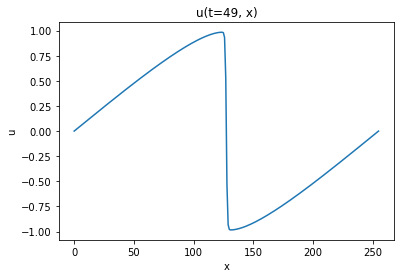

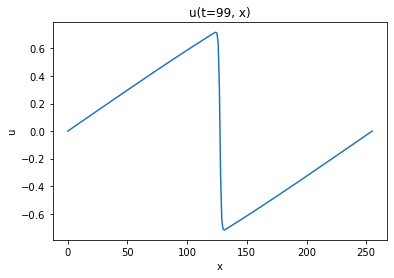

In [2]:
# import data from file
data = scipy.io.loadmat('burgers_shock.mat')

print('Lengitude x: ', len(data['x']) )
print('Lengitude t: ', len(data['t']) )
print('Number of points: ',  len(data['x']) * len(data['t']) )
print('image dimension: ', data['usol'].shape)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data['usol'], cmap='hot' )
plt.show()
tt = np.linspace(0, len(data['t'])-1, 3, dtype=int)
for i in tt:
    plt.plot(data['usol'][:,i])
    plt.title('u(t=' + str(i) + ', x)')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.show()

### 2.1 Data Preprocesing

The data must be separated between training data and test data. In this case we will select the approximate number of data we want to use to train the model.

In [3]:
def Dataset(data=data, tr_n=2000):
    u_tr = []                                     
    x_tr = []
    t_tr = []

    u_te = []                                
    x_te = []
    t_te = [] 

    prob = tr_n / (data['usol'].shape[0]*data['usol'].shape[1])

    for x, u_t in zip(data['x'],data['usol'] ):
        x = x[0]
        for t, u in zip(data['t'], u_t):
            t = t[0]
            if random.random() > prob:
                u_te.append([u])
                x_te.append([x])
                t_te.append([t])


            else:
                u_tr.append([u])
                x_tr.append([x])
                t_tr.append([t])

    x_tr = torch.tensor(x_tr, requires_grad=True).float()
    x_te = torch.tensor(x_te, requires_grad=True).float()
    t_tr = torch.tensor(t_tr, requires_grad=True).float()
    t_te = torch.tensor(t_te, requires_grad=True).float()
    u_tr = torch.tensor(u_tr).float()
    u_te = torch.tensor(u_te).float()
    
    return [x_tr, t_tr, u_tr], [x_te, t_te, u_te]

## 3. Neural Network
The brilliant idea that differentiates a PINN from other Neural Networks is to "Teach Physics" to the Neural Network.
### 3.1 Teaching Physics to a NN?
In principle, the idea seems ideal, but it is strange to implement in a neural network. The first thing we need to know is that the mathematical tools we have to describe all natural events in our environment are differential equations, In this case I am going to simulate the Burgers equation described in section 1.1.

For this reason, we must require our model that the predicted u(t,x) satisfies the equation, and include the deviation of in the value of the loss. To test the PINN we will introduce in the NN 2 parameters that the model need find
$ \upsilon_1 $ and $ \upsilon_2 $.

$\frac{\partial u_{predicted}}{\partial t} +\upsilon_1 \frac{\partial u_{predicted}}{\partial x} - \upsilon_2\frac{\partial^2 u_{predicted}}{\partial x^2} ) $ 

Where $ \upsilon_1 = 1 $ and $ \upsilon_2 = \frac{0.1}{pi}$.

### 3.2 Loos function
The lost function for this model is:
$ MSE(u(x,t)-u_{predicted}(x,t))+MSE( \frac{\partial u_{predicted}}{\partial t} +\upsilon_1 \frac{\partial u_{predicted}}{\partial x} - \upsilon_2\frac{\partial^2 u_{predicted}}{\partial x^2} )$ 


# 3.3 Dense Neural Network
The first step is create a Dense Neural Network that predict u(x,t)

In [32]:
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        
        # Inpunt Layer
        self.linear1 = nn.Linear(2, 20)
        
        # Capa Oculta
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, 20)
        self.linear4 = nn.Linear(20, 20)
        self.linear5 = nn.Linear(20, 20)
        self.linear6 = nn.Linear(20, 20)
        self.linear7 = nn.Linear(20, 20)
        self.linear8 = nn.Linear(20, 20)
        self.linear9 = nn.Linear(20, 20)
        
        # Output Layer
        self.linear10 = nn.Linear(20, 1)
        
        # BatchNorm Layer
        #self.BN1 = nn.BatchNorm1d(20)
        #self.BN2 = nn.BatchNorm1d(20)
        #self.BN3 = nn.BatchNorm1d(20)
        #self.BN4 = nn.BatchNorm1d(20)
        #self.BN5 = nn.BatchNorm1d(200)
        
        # Activation Function
        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.tanh3 = nn.Tanh()
        self.tanh4 = nn.Tanh()
        self.tanh5 = nn.Tanh()
        self.tanh6 = nn.Tanh()
        self.tanh7 = nn.Tanh()
        self.tanh8 = nn.Tanh()
        self.tanh9 = nn.Tanh()
        
        # Drop out
        #self.dropout1 = nn.Dropout(0.5)
        #self.dropout2 = nn.Dropout(0.3)
        #self.dropout3 = nn.Dropout(0.1)
        
    def forward(self, x):
        
        x = self.linear1(x)
        x = self.tanh1(x)
        #x = self.BN1(x)
        x = self.linear2(x)
        #x = self.BN2(x)
        x = self.tanh2(x)
        #x = self.dropout1(x)
        x = self.linear3(x)
        x = self.tanh3(x)
        #x = self.BN3(x)
        x = self.linear4(x)
        x = self.tanh4(x)
        #x = self.BN4(x)
        #x = self.dropout2(x)
        x = self.linear5(x)
        x = self.tanh5(x)
        #x = self.BN5(x)
        x = self.linear6(x)
        x = self.tanh6(x)
        #x = self.dropout3(x)
        x = self.linear7(x)
        x = self.tanh7(x)
        x = self.linear8(x)
        x = self.tanh8(x)
        x = self.linear9(x)
        x = self.tanh9(x)
        x = self.linear10(x)
        
        return x

### 3.2 Hyperparameters and Data

In [9]:
device = 'cuda'

tr, te = Dataset(data=data, tr_n=2000)
x_tr = tr[0].to(device)
t_tr = tr[1].to(device)
u_tr = tr[2].to(device)
x_te = te[0]#.to(device)
t_te = te[1]#.to(device)
u_te = te[2]#.to(device)

## 4.  Develop Physical Informed Neural Network (FINN)
It is necesary introcuce the 2 extra parameters $ \upsilon_1 $ and $ \upsilon_2 $, and give them a initial value. 

In [37]:
class PINN():
    def __init__(self, x, t, u, l1=0.0, l2=-6.0):#, l2=0.01/np.pi):
        # Data
        self.x = x.to(device)
        self.t = t.to(device)
        self.u = u.to(device) 
        
        # # It is necesary introcuce the 2 extra parameters  𝜐1  and  𝜐2, and give them a initial value
        self.lambda_1 = torch.tensor([l1], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([l2], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        
        self.dnn = DNN().to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
        # Optimizador: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=0.1, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr=0.0001, betas=(0.9, 0.999))
        self.iter = 0
        
    #### Create the function that calculate the Burgers ec.
    def Brg_ec(self, u):
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        #lambda_2 = self.lambda_2
        
        u_x = torch.autograd.grad(u, self.x, 
                                grad_outputs=torch.ones_like(u),
                                retain_graph=True,
                                create_graph=True)[0] 
        
        u_t = torch.autograd.grad(u, self.t, 
                                grad_outputs=torch.ones_like(u),
                                retain_graph=True,
                                create_graph=True)[0]
        
        u_xx = torch.autograd.grad(u_x, self.x, 
                                grad_outputs=torch.ones_like(u_x),
                                retain_graph=True,
                                create_graph=True)[0] 
        
        return  u_t + self.lambda_1 * u * u_x -  torch.exp(self.lambda_2) * u_xx # Ecuacion de Burguer

    # Function to introduce all x and y values in the Dense NN to pedict u(x,t)
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    ### Define the Loss function
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.Brg_ec(u_pred)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print( 'Item: ', self.iter, ' => ', 'Loss: ',  loss.item(),' ; ',
                      'Landa 1: ', self.lambda_1.item(),' ; ',
                      'Landa 2: ',  torch.exp(self.lambda_2).item() )
        return loss
            
    
    def train(self, n_epochs=0):
        self.dnn.train()
        Loss = []
        for epoch in range(n_epochs):
            
            u_pred = self.dnn(torch.cat([self.x, self.t], dim=1))
            f_pred = self.Brg_ec(u_pred)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            Loss.append(loss.item())
            if epoch%100 == 0:    #after test differnt options number epochs = 0, have the best result
                print( 'Epoch: ', epoch, ' => ', 'Loss: ',  loss.item(),' ; ',
                      'Landa 1: ', self.lambda_1.item(),' ; ',
                      'Landa 2: ',  torch.exp(self.lambda_2).item() )

        self.optimizer.step(self.loss_func)
        return self.dnn.to('cpu')

## 5. Train the model

In [38]:
model = PINN(x_tr, t_tr, u_tr)
dnn = model.train() 

Item:  100  =>  Loss:  0.02844422683119774  ;  Landa 1:  0.08958758413791656  ;  Landa 2:  0.002497620414942503
Item:  200  =>  Loss:  0.01967500150203705  ;  Landa 1:  0.2499057799577713  ;  Landa 2:  0.002462889300659299
Item:  300  =>  Loss:  0.015780339017510414  ;  Landa 1:  0.43726861476898193  ;  Landa 2:  0.002888079034164548
Item:  400  =>  Loss:  0.010428770445287228  ;  Landa 1:  0.5554052591323853  ;  Landa 2:  0.0034790204372256994
Item:  500  =>  Loss:  0.007331184111535549  ;  Landa 1:  0.6574709415435791  ;  Landa 2:  0.004146438557654619
Item:  600  =>  Loss:  0.004966935142874718  ;  Landa 1:  0.7149662375450134  ;  Landa 2:  0.0047829123213887215
Item:  700  =>  Loss:  0.003587809856981039  ;  Landa 1:  0.7827548980712891  ;  Landa 2:  0.005222545936703682
Item:  800  =>  Loss:  0.0026226737536489964  ;  Landa 1:  0.8509507179260254  ;  Landa 2:  0.005488019436597824
Item:  900  =>  Loss:  0.0022188141010701656  ;  Landa 1:  0.8519004583358765  ;  Landa 2:  0.0057245

## 6. Test the model

In [43]:
u_pred = dnn(torch.cat([x_te, t_te], dim=1))
error = np.linalg.norm(u_te-u_pred.detach().cpu().numpy(),2)/np.linalg.norm(u_te,2)
print('Expected lambda 1: 1', ';', 'Predicted lambda 1: ', model.lambda_1.item())
print('Expected lambda 2: ', (0.01/np.pi), ';', 'Predicted lambda 2: ', torch.exp(model.lambda_2).item())
print('Model error: ', error)

Expected lambda 1: 1 ; Predicted lambda 1:  0.9957439303398132
Expected lambda 2:  0.003183098861837907 ; Predicted lambda 2:  0.0032737788278609514
Model error:  0.008399875
